In [2]:
import numpy as np
import os
import librosa
import librosa.display
from IPython import display
from matplotlib import pyplot

from sklearn.tree import ExtraTreeClassifier

In [3]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

In [4]:
datasubdir = 'data/'
datadir = os.path.join(os.path.abspath('.'), datasubdir)

In [5]:
subject_names = ['s'+str(i) for i in range(1,10+1)]
trial_names = ['downstairs_nowall', 'downstairs_wall', 'upstairs_nowall', 'upstairs_wall']
trial_names = [os.path.join(s, s + '_' + i+'_'+j) 
               for s in subject_names
               for i in trial_names 
               for j in ['trial1', 'trial2']]
angle_names = [alph[0] + num[0] + '_' + alph[1] + '_' + num[1]  
               for alph in [('A', '1'), ('B', '3'), ('C', '5')]
               for num in [(str(i),str(45*i)) for i in range(3)]]
recording_paths = [os.path.join(datadir, t,a) for t in trial_names 
                                              for a in angle_names]

files_of_interest = []
print(recording_paths[0])
print(os.listdir(recording_paths[0]))

/home/em/school/cpsc554x/proj/data/s1/s1_downstairs_nowall_trial1/A0_1_0
['recording1_0_2.wav', 'recording0_225_4.wav', 'recording1_135_5.wav', 'recording1_180_1.wav', 'recording1_135_0.wav', 'recording1_90_5.wav', 'recording1_45_0.wav', 'recording0_90_0.wav', 'recording1_45_1.wav', 'recording1_270_4.wav', 'recording1_315_0.wav', 'recording1_0_3.wav', 'recording1_135_2.wav', 'recording0_45_2.wav', 'recording1_225_0.wav', 'recording1_135_4.wav', 'recording0_225_1.wav', 'recording0_315_3.wav', 'recording1_45_3.wav', 'recording0_135_0.wav', 'recording1_0_4.wav', 'recording0_90_1.wav', 'recording0_315_4.wav', 'recording0_270_5.wav', 'recording1_180_5.wav', 'recording1_180_4.wav', 'recording0_0_2.wav', 'recording0_270_2.wav', 'recording0_225_2.wav', 'recording0_0_5.wav', 'recording0_225_3.wav', 'recording0_0_4.wav', 'recording0_270_3.wav', 'recording1_225_2.wav', 'recording1_90_1.wav', 'recording0_315_2.wav', 'recording0_225_0.wav', 'recording1_90_2.wav', 'recording1_90_3.wav', 'recording0_

In [44]:
# Credit to Yihui Xiong, 2017, https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py

def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [45]:
recordings_of_interest = [os.path.join(recording_paths[0], f'recording0_45_{i}.wav') for i in range(1,5)]
audio_files = [Audio.fromfile(r) for r in recordings_of_interest]
four_channels = [a.data for a in audio_files]
gcc_phat_data = [gcc_phat(four_channels[i],four_channels[j], fs = audio_files[0].rate, max_tau=0.236 * 1e-3, interp=1)
     for i in range(len(four_channels))
     for j in range(i,len(four_channels))]
gcc_phat_data

[(0.0,
  array([-1.26317163e-19, -8.10165381e-21,  1.11763753e-19,  0.00000000e+00,
         -1.21853820e-19, -6.70326821e-20,  2.50697252e-19,  7.09138315e-21,
         -1.39493290e-19, -1.88278017e-19, -1.07812439e-19,  1.00000000e+00,
         -1.07812439e-19, -1.88278017e-19, -1.39493290e-19,  7.09138315e-21,
          2.50697252e-19, -6.70326821e-20, -1.21853820e-19,  0.00000000e+00,
          1.11763753e-19, -8.10165381e-21, -1.26317163e-19])),
 (0.0,
  array([ 3.54618724e-04,  2.44678663e-04, -3.41077198e-02, -3.99099257e-04,
          9.50074267e-04,  2.26418727e-02,  1.29579757e-03,  6.10223740e-04,
         -4.56996063e-02,  3.37222000e-04,  1.31443157e-03,  8.61144250e-01,
          1.46116978e-03,  1.16592945e-04,  1.13376184e-01,  1.77618272e-04,
          1.28652558e-03, -3.84179156e-02,  1.16820942e-03,  7.57679216e-04,
          4.59789681e-02,  3.94526782e-04,  5.78969692e-04])),
 (-0.000125,
  array([ 3.35212767e-04,  3.21843571e-05, -2.73365329e-01,  5.50479286e-04,


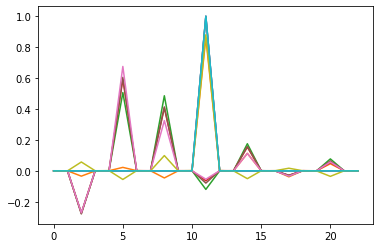

In [53]:
for i in range(len(gcc_phat_data)):
    pyplot.plot(gcc_phat_data[i][1])


In [50]:
recordings_of_interest_0 = [os.path.join(recording_paths[0], f'recording0_0_{i}.wav') for i in range(1,5)]
audio_files_0 = [Audio.fromfile(r) for r in recordings_of_interest_0]
four_channels_0 = [a.data for a in audio_files_0]
gcc_phat_data_0 = [gcc_phat(four_channels_0[i],four_channels_0[j], fs = audio_files_0[0].rate, max_tau=0.236 * 1e-3, interp=1)
     for i in range(len(four_channels_0))
     for j in range(i,len(four_channels_0))]

In [51]:
gcc_phat_data_0

[(0.0,
  array([ 1.44883252e-18, -5.13170744e-19, -1.14694628e-18,  7.21964444e-18,
          6.29475033e-20, -2.99203349e-18, -2.19342461e-19,  1.16004444e-18,
         -2.65619667e-19, -2.03179257e-18,  7.09890631e-19,  1.00000000e+00,
         -2.82919798e-19,  1.12868164e-18,  1.64627372e-18, -1.55507762e-19,
          9.09820776e-19, -2.48243829e-18,  1.01181435e-18,  4.91988580e-18,
          7.38865636e-19, -1.18759619e-18, -5.90915011e-19])),
 (0.0,
  array([ 3.57187443e-05,  5.41789136e-04,  2.99801006e-03,  7.25810906e-06,
          9.44850351e-04, -3.79142045e-02,  4.26816705e-04,  1.21916741e-03,
          7.12702144e-02,  8.08592473e-04,  1.05105719e-03,  9.18024305e-01,
          5.61639890e-04, -1.95059165e-04, -7.84219084e-02,  8.00108965e-04,
          9.52148386e-04,  4.25999057e-02,  5.01540978e-04,  8.31545510e-04,
          1.68856896e-03,  1.71443576e-04,  9.97336054e-04])),
 (-0.000125,
  array([-7.65754232e-05,  1.08640553e-03, -2.93051891e-01,  1.71852673e-04,


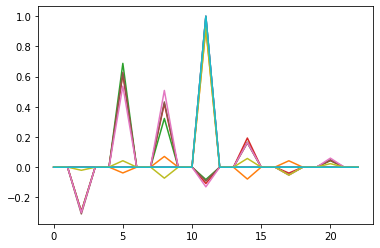

In [55]:
for i in range(len(gcc_phat_data_0)):
    pyplot.plot(gcc_phat_data_0[i][1])

In [17]:
[four_channels[i].size for i in range(len(four_channels))]

[42864, 42864, 42864, 42864]

In [21]:
audio_files_0[0].rate

48000

In [ ]:
# we want: 
# - raw GCC output (cropped +- 0.236ms)
# - max peak value
# - max peak index (which is the TDOA)
# - area under the curve